In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn import metrics
from keras.models import load_model
import os
import time

Using TensorFlow backend.


In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

DATASET_PATH = "/home/hadoop/data/UCI HAR Dataset/"

The data is already downloaded in LSRM. Let's begin with preparing dataset

In [3]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [4]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7352, 128, 9)
(2947, 128, 9)
(7352, 1)
(2947, 1)


In [10]:
# define some parameters

num_sequential = 128 # number of input sequence
num_sensor = 9 # number of sensor
num_output = 6 # number of output kinds
batch_size = 100
epochs = 50

In [6]:
# one hot encoding for y
def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


In [8]:
# LSTM networks

model = Sequential()
model.add(LSTM(num_sequential/2, dropout=0.2,return_sequences=True,
                   input_shape=(num_sequential, num_sensor)))
model.add(LSTM(num_sequential/4, dropout=0.2,return_sequences=True))
model.add(LSTM(num_sequential/8, dropout=0.2))
model.add(Dense(num_output, activation='sigmoid'))

# plot_model(model)

In [15]:
# reload model
model = load_model('lstm_keras_UCI_40epoches.h5')

In [11]:
results = []
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, one_hot(y_train),
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, one_hot(y_test)))
average_time_per_epoch = (time.time() - start_time) / epochs

results.append((history, average_time_per_epoch))

Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 152s - loss: 0.3440 - acc: 0.8621 - val_loss: 0.3400 - val_acc: 0.8614
Epoch 2/50
7352/7352 [==============================] - 148s - loss: 0.3316 - acc: 0.8629 - val_loss: 0.3342 - val_acc: 0.8621
Epoch 3/50
7352/7352 [==============================] - 153s - loss: 0.3226 - acc: 0.8714 - val_loss: 0.3149 - val_acc: 0.8756
Epoch 4/50
7352/7352 [==============================] - 153s - loss: 0.3153 - acc: 0.8762 - val_loss: 0.3214 - val_acc: 0.8709
Epoch 5/50
7352/7352 [==============================] - 149s - loss: 0.3030 - acc: 0.8759 - val_loss: 0.2934 - val_acc: 0.8751
Epoch 6/50
7352/7352 [==============================] - 155s - loss: 0.3262 - acc: 0.8733 - val_loss: 0.3198 - val_acc: 0.8769
Epoch 7/50
7352/7352 [==============================] - 153s - loss: 0.3102 - acc: 0.8740 - val_loss: 0.3161 - val_acc: 0.8746
Epoch 8/50
7352/7352 [==============================] - 150s - 

In [12]:
model.save('lstm_keras_UCI_twoLSTM_50e.h5')

/home/hadoop/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


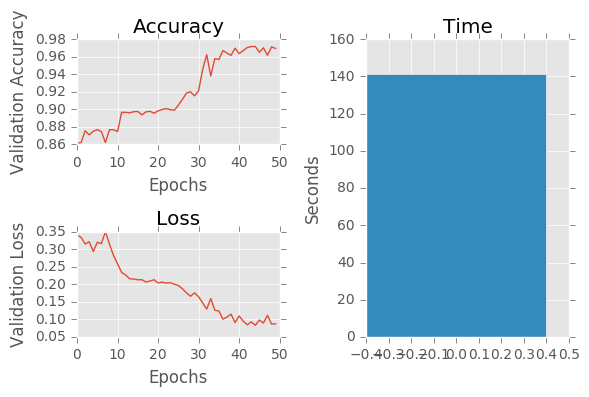

In [13]:
# Compare models' accuracy, loss and elapsed time per epoch.
plt.style.use('ggplot')
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.set_title('Accuracy')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xlabel('Epochs')
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.set_title('Loss')
ax2.set_ylabel('Validation Loss')
ax2.set_xlabel('Epochs')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
ax3.set_title('Time')
ax3.set_ylabel('Seconds')

for result in results:
    ax1.plot(result[0].epoch, result[0].history['val_acc'])
    ax2.plot(result[0].epoch, result[0].history['val_loss'])

ax1.legend()
ax2.legend()
ax3.bar(np.arange(len(results)), [x[1] for x in results],
         align='center')
plt.tight_layout()
plt.show()

('Test loss:', 0.087539668728082026)
('Test accuracy:', 0.96940391444739216)

Accuracy: 90.7702748558%
Recall: 90.7702748558%
f1_score: 90.7913284948%

Confusion Matrix:
[[464   3  29   0   0   0]
 [ 17 440  14   0   0   0]
 [  6   2 412   0   0   0]
 [  0   3   1 382 105   0]
 [  0   0   0  81 451   0]
 [  0   0   0   0  11 526]]

Confusion matrix (normalised to % of total test data):
[[ 15.74482441   0.10179844   0.98405153   0.           0.           0.        ]
 [  0.57685781  14.93043709   0.47505939   0.           0.           0.        ]
 [  0.20359688   0.06786563  13.98031902   0.           0.           0.        ]
 [  0.           0.10179844   0.03393281  12.96233368   3.5629456    0.        ]
 [  0.           0.           0.           2.74855804  15.30369854   0.        ]
 [  0.           0.           0.           0.           0.37326095
   17.84865952]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the d

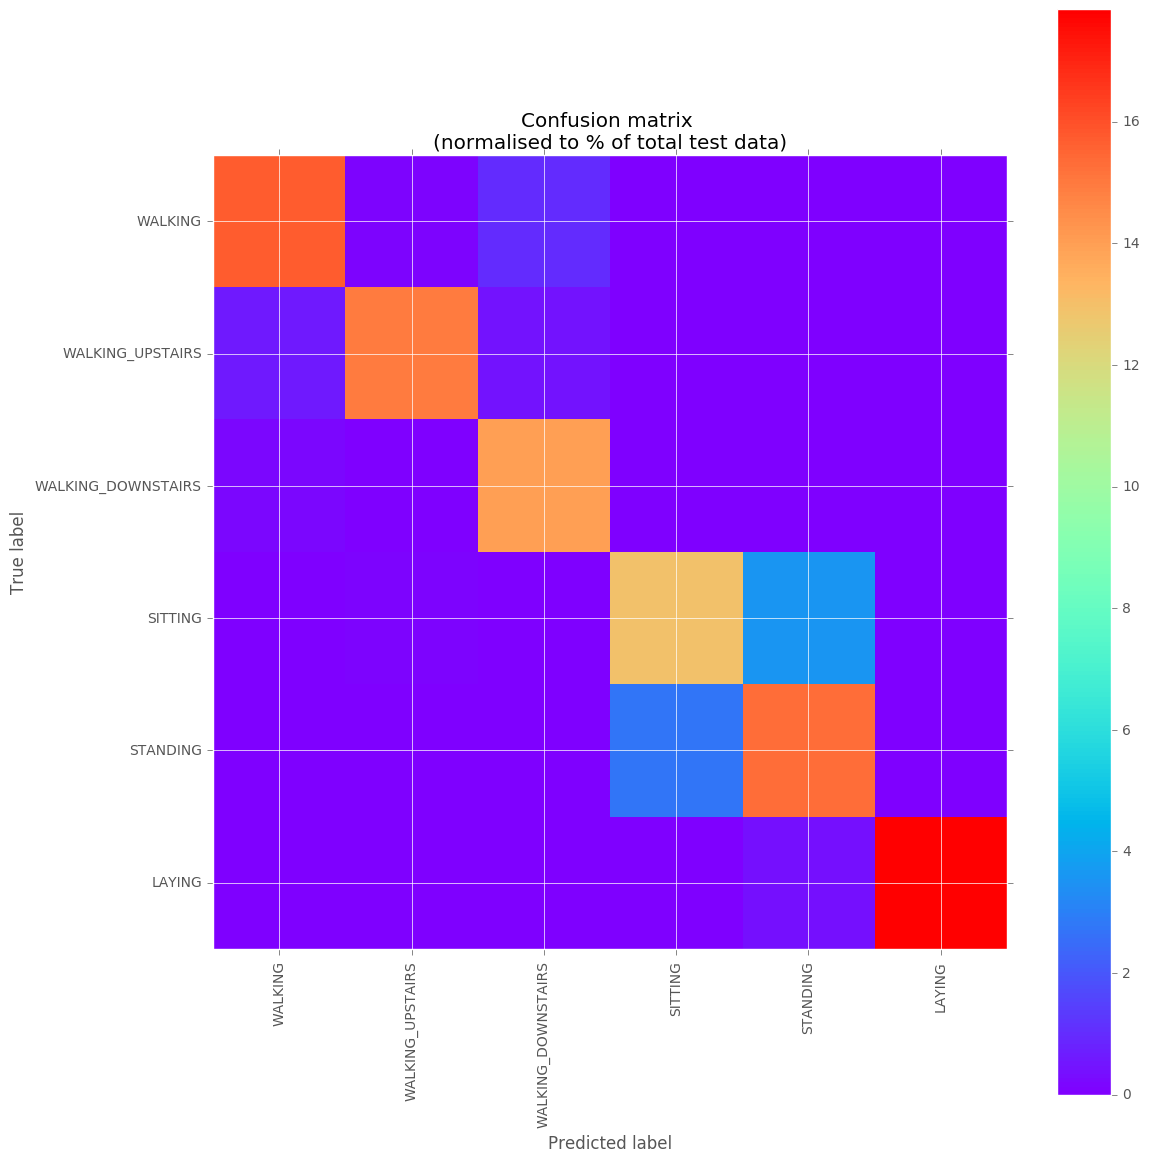

In [15]:
# Results

score = model.evaluate(X_test, one_hot(y_test), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

predictions_one_hot = model.predict(X_test)
predictions = predictions_one_hot.argmax(1)

# print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Accuracy: {}%".format(100*metrics.accuracy_score(y_test, predictions)))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
# confusion_matrix = metrics.confusion_matrix(one_hot(y_test), predictions_one_hot)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")



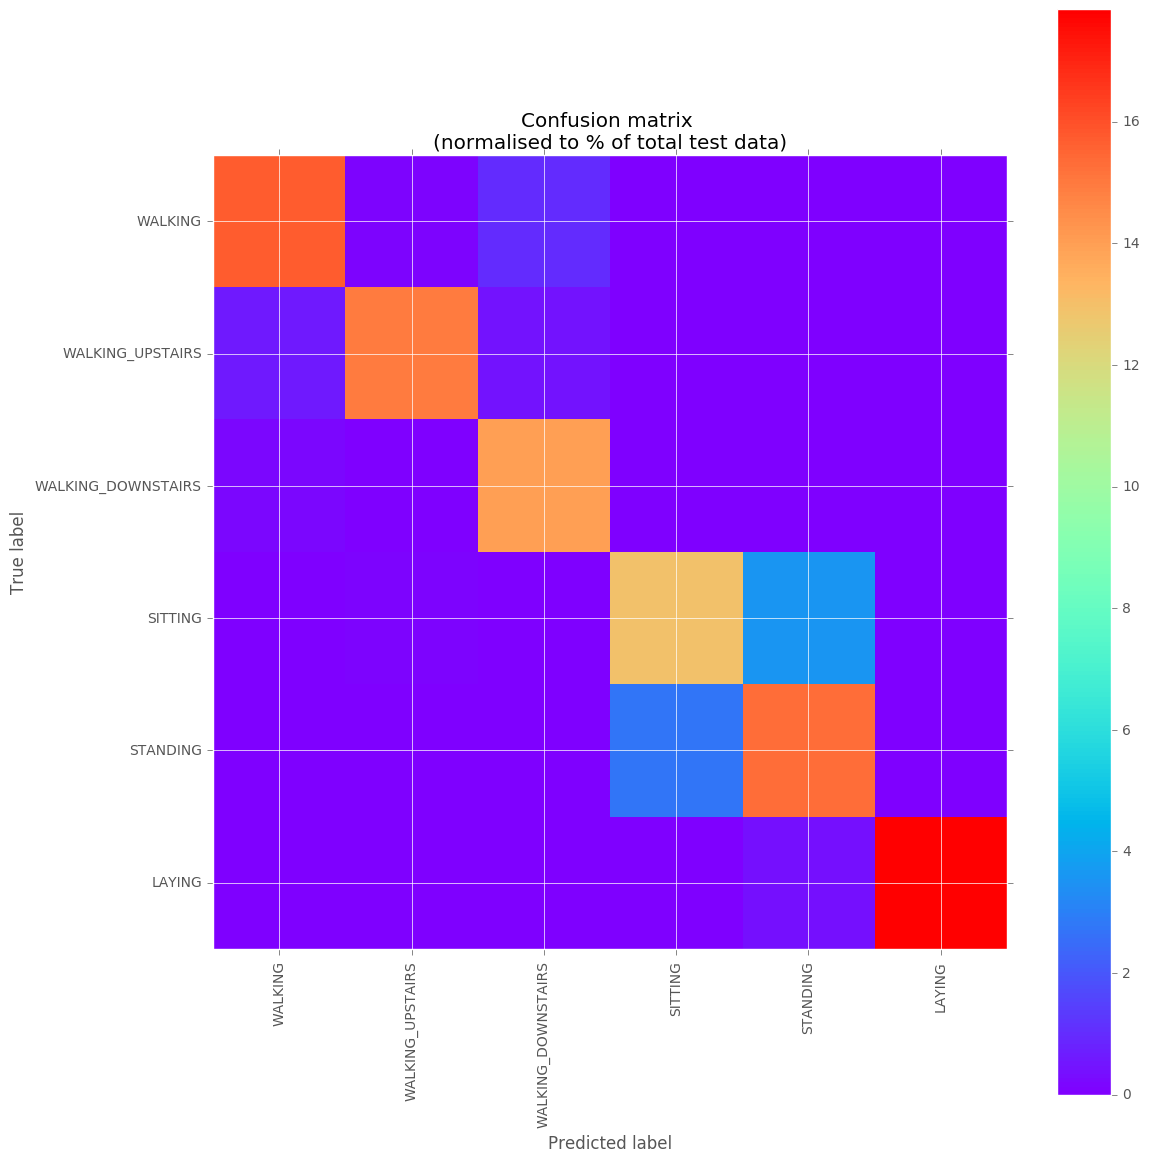

In [16]:
# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(num_output)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()